In [1]:
# HIDDEN
import matplotlib
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
import numpy as np
import math
import scipy.stats as stats
plots.style.use('fivethirtyeight')

## Building a model

So far, we have talked about *prediction*, where the purpose of learning is to be able to predict the class of new instances.  I'm now going to switch to *model building*, where the goal is to learn a model of how the class depends upon the attributes.

One place where model building is useful is for science: e.g., which genes influence whether you become diabetic?  This is interesting and useful in its right (apart from any applications to predicting whether a particular individual will become diabetic), because it can potentially help us understand the workings of our body.

Another place where model building is useful is for control: e.g., what should I change about my advertisement to get more people to click on it?  How should I change the profile picture I use on an online dating site, to get more people to "swipe right"?  Which attributes make the biggest difference to whether people click/swipe?  Our goal is to determine which attributes to change, to have the biggest possible effect on something we care about.

We already know how to build a classifier, given a training set.  Let's see how to use that as a building block to help us solve these problems.

How do we figure out which attributes have the biggest influence on the output?  Take a moment and see what you can come up with.

## Feature selection

Background: attributes are also called *features*, in the machine learning literature.

Our goal is to find a subset of features that are most relevant to the output.  The way we'll formalize is this is to identify a subset of features that, when we train a classifier using just those features, gives the highest possible accuracy at prediction.

Intuitively, if we get 90% accuracy using all the features and 88% accuracy using just three of the features (for example), then it stands to reason that those three features are probably the most relevant, and they capture most of the information that affects or determines the output.

With this insight, our problem becomes:

> Find the subset of $\ell$ features that gives the best possible accuracy (when we use only those $\ell$ features for prediction).

This is a feature selection problem.  There are many possible approaches to feature selection.  One simple one is to try all possible ways of choosing $\ell$ of the features, and evaluate the accuracy of each.  However, this can be very slow, because there are so many ways to choose a subset of $\ell$ features.

Therefore, we'll consider a more efficient procedure that often works reasonably well in practice.  It is known as greedy feature selection.  Here's how it works.

1. Suppose there are $d$ features.  Try each on its own, to see how much accuracy we can get using a classifier trained with just that one feature.  Keep the best feature.

2. Now we have one feature.  Try remaining $d-1$ features, to see which is the best one to add to it (i.e., we are now training a classifier with just 2 features: the best feature picked in step 1, plus one more).  Keep the one that best improves accuracy.  Now we have 2 features.

3. Repeat.  At each stage, we try all possibilities for how to add one more feature to the feature subset we've already picked, and we keep the one that best improves accuracy.

Let's implement it and try it on some examples!

## Code for k-NN

First, some code from last time, to implement $k$-nearest neighbors.

In [2]:
def distance(pt1, pt2):
    tot = 0
    for i in range(len(pt1)):
        tot = tot + (pt1[i] - pt2[i])**2
    return math.sqrt(tot)

In [3]:
def computetablewithdists(training, p):
    dists = np.zeros(training.num_rows)
    attributes = training.drop('Class').rows
    for i in range(training.num_rows):
        dists[i] = distance(attributes[i], p)
    withdists = training.copy()
    withdists.append_column('Distance', dists)
    return withdists

def closest(training, p, k):
    withdists = computetablewithdists(training, p)
    sortedbydist = withdists.sort('Distance')
    topk = sortedbydist.take(range(k))
    return topk

def majority(topkclasses):
    if topkclasses.where('Class', 1).num_rows > topkclasses.where('Class', 0).num_rows:
        return 1
    else:
        return 0

def classify(training, p, k):
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [4]:
def evaluate_accuracy(training, valid, k):
    validattrs = valid.drop('Class')
    numcorrect = 0
    for i in range(valid.num_rows):
        # Run the classifier on the ith patient in the test set
        c = classify(training, validattrs.rows[i], k)
        # Was the classifier's prediction correct?
        if c == valid['Class'][i]:
            numcorrect = numcorrect + 1
    return numcorrect / valid.num_rows

## Code for feature selection

Now we'll implement the feature selection algorithm.  First, a subroutine to evaluate the accuracy when using a particular subset of features:

In [5]:
def evaluate_features(training, valid, features, k):
    tr = training.select(['Class']+features)
    va = valid.select(['Class']+features)
    return evaluate_accuracy(tr, va, k)

Next, we'll implement a subroutine that, given a current subset of features, tries all possible ways to add one more feature to the subset, and evaluates the accuracy of each candidate.  This returns a table that summarizes the accuracy of each option it examined.

In [6]:
def try_one_more_feature(training, valid, baseattrs, k):
    results = Table(['Attribute', 'Accuracy'])
    for attr in training.drop(['Class']+baseattrs).labels:
        acc = evaluate_features(training, valid, [attr]+baseattrs, k)
        results.append((attr, acc))
    return results.sort('Accuracy', descending=True)

Finally, we'll implement the greedy feature selection algorithm, using the above subroutines.  For our own purposes of understanding what's going on, I'm going to have it print out, at each iteration, all features it considered and the accuracy it got with each.

In [7]:
def select_features(training, valid, k, maxfeatures=3):
    results = Table(['NumAttrs', 'Attributes', 'Accuracy'])
    curattrs = []
    iters = min(maxfeatures, len(training.labels)-1)
    while len(curattrs) < iters:
        print('== Computing best feature to add to '+str(curattrs))
        # Try all ways of adding just one more feature to curattrs
        r = try_one_more_feature(training, valid, curattrs, k)
        r.show()
        print()
        # Take the single best feature and add it to curattrs
        attr = r['Attribute'][0]
        acc = r['Accuracy'][0]
        curattrs.append(attr)
        results.append((len(curattrs), ', '.join(curattrs), acc))
    return results

## Example: Tree Cover

Now let's try it out on an example.  I'm working with a data set gathered by the US Forestry service.  They visited thousands of wildnerness locations and recorded various characteristics of the soil and land.  They also recorded what kind of tree was growing predominantly on that land.  Focusing only on areas where the tree cover was either Spruce or Lodgepole Pine, let's see if we can figure out which characteristics have the greatest effect on whether the predominant tree cover is Spruce or Lodgepole Pine.

There are 500,000 records in this data set -- more than I can analyze with the software we're using.  So, I'll pick a random sample of just a fraction of these records, to let us do some experiments that will complete in a reasonable amount of time.

In [8]:
all_trees = Table.read_table('treecover2.csv.gz', sep=',')
training   = all_trees.take(range(   0, 1000))
validation = all_trees.take(range(1000, 1500))
test       = all_trees.take(range(1500, 2000))

In [9]:
training.show(2)

Elevation,Aspect,Slope,HorizDistToWater,VertDistToWater,HorizDistToRoad,Hillshade9am,HillshadeNoon,Hillshade3pm,HorizDistToFire,Area1,Area2,Area3,Area4,Class
2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,1
2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,1


Let's start by figuring out how accurate a classifier will be, if trained using this data.  I'm going to arbitrarily use $k=15$ for the $k$-nearest neighbor classifier.

In [10]:
evaluate_accuracy(training, validation, 15)

0.572

Now we'll apply feature selection.  I wonder which characteristics have the biggest influence on whether Spruce vs Lodgepole Pine grows?  We'll look for the best 4 features.

In [11]:
best_features = select_features(training, validation, 15)

== Computing best feature to add to []


Attribute,Accuracy
Elevation,0.762
HorizDistToRoad,0.562
HorizDistToFire,0.534
Hillshade9am,0.518
Hillshade3pm,0.516
Slope,0.516
Area4,0.514
Area3,0.514
Area2,0.514
Area1,0.514



== Computing best feature to add to ['Elevation']


Attribute,Accuracy
HorizDistToWater,0.782
Hillshade9am,0.776
Slope,0.77
Hillshade3pm,0.768
Area4,0.762
Area3,0.762
Area2,0.762
Area1,0.762
VertDistToWater,0.762
Aspect,0.75



== Computing best feature to add to ['Elevation', 'HorizDistToWater']


Attribute,Accuracy
Hillshade3pm,0.792
HillshadeNoon,0.792
Slope,0.784
Aspect,0.784
Area4,0.782
Area3,0.782
Area2,0.782
Area1,0.782
Hillshade9am,0.78
VertDistToWater,0.776


In [12]:
best_features

NumAttrs,Attributes,Accuracy
1,Elevation,0.762
2,"Elevation, HorizDistToWater",0.782
3,"Elevation, HorizDistToWater, Hillshade3pm",0.792


As we can see, Elevation looks like far and away the most discriminative feature.  This suggests that this characteristic might play a large role in the biology of which tree grows best, and thus might tell us something about the science.

What about the horizontal distance to water and the amount of shade at 3pm?  It looks like they might also be predictive, and thus might play a role in the biology as well -- assuming the apparent improvement in accuracy is real, and we're not just fooling ourselves.

## Hold-out sets: Training, Validation, Testing

Suppose we built a predictor using just the best two features, Elevation and HorizDistToWater.  How accurate would we expect it to be, on the entire population of locations?  78.2% accurate?  more?  less?  Why?

Well, at this point, it's hard to tell.  It's the same issue we mentioned earlier about fooling ourselves.  We've tried multiple different approaches, and taken the best; if we then evaluate it on the same data set we used to select which is best, we will get a biased numbers -- it might not be an accurate estimate of the true accuracy.

Why?  Our data set is noisy.  We've looked for correlations, and kept the association that had the highest correlation in our training set.  But was that a real relationship, or was it just noise?  If you pick a single attribute and measure its accuracy on a sample, we'd expect this to be a reasonable approximation to its accuracy on the entire population, but with some random error.  If we look at 100 possible combinations and choose the best, it's possible we found one whose accuracy on the entire population is indeed large -- or it's possible we were just selecting the one whose error term happened to be the largest of the 100.

For these reasons, we can't expect the accuracy numbers we've computed above to necessarily be a good, unbiased measure of the accuracy on the entire population.

The way to get an unbiased estimate of accuracy is the same as last lecture: get some more data; or set some aside in the beginning so we have more when we need it.  In this case, I set aside two extra chunks of data, a *validation* data set and a *test* data set.  I used the validation set to select a few best features.  Now we're going to measure the performance of this on the test set, just to see what happens.

In [13]:
evaluate_features(training, validation, ['Elevation'], 15)

0.762

In [14]:
evaluate_features(training, test, ['Elevation'], 15)

0.712

In [15]:
evaluate_features(training, validation, ['Elevation', 'HorizDistToWater'], 15)

0.782

In [16]:
evaluate_features(training, test, ['Elevation', 'HorizDistToWater'], 15)

0.742

Why do you think we see this difference?

To get a better feeling for this, we can look at all of our different features, and compare its accuracy on the training set vs its accuracy on the validation set, to see how much random error there is in these accuracy figures.  If there was no error, then both accuracy numbers would always be the same, but as we'll see, in practice there is some error, because computing the accuracy on a sample is only an approximation to the accuracy on the entire population.

In [19]:
accuracies = Table(['Validation Accuracy', 'Accuracy on another sample'])
another_sample = all_trees.take(range(2000, 2500))
for feature in training.drop('Class').labels:
    x = evaluate_features(training, validation, [feature], 15)
    y = evaluate_features(training, another_sample, [feature], 15)
    accuracies.append((x,y))
accuracies.sort('Validation Accuracy')

Validation Accuracy,Accuracy on another sample
0.502,0.346
0.51,0.384
0.51,0.35
0.512,0.358
0.514,0.342
0.514,0.342
0.514,0.342
0.514,0.342
0.516,0.366
0.516,0.352


/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


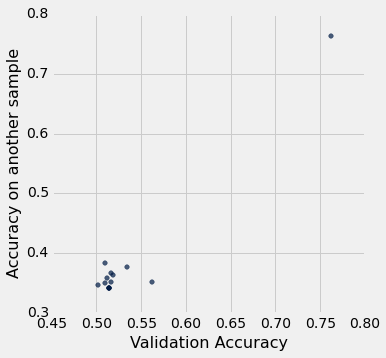

In [20]:
accuracies.scatter('Validation Accuracy')

## Thought Questions

Suppose that the top two attributes had been Elevation and HorizDistToRoad.  Interpret this for me.  What might this mean for the biology of trees?  One possible explanation is that the  distance to the nearest road affects what kind of tree grows; can you give any other possible explanations?

Once we know the top two attributes are Elevation and HorizDistToWater, suppose we next wanted to know *how* they affect what kind of tree grows: e.g., does high elevation tend to favor spruce, or does it favor lodgepole pine?  How would you go about answering these kinds of questions?

The scientists also gathered some more data that I left out, for simplicity: for each location, they also gathered what kind of soil it has, out of 40 different types.  The original data set had a column for soil type, with numbers from 1-40 indicating which of the 40 types of soil was present.  Suppose I wanted to include this among the other characteristics.  What would go wrong, and how could I fix it up?

For this example we picked $k=15$ arbitrarily.  Suppose we wanted to pick the best value of $k$ -- the one that gives the best accuracy.  How could we go about doing that?  What are the pitfalls, and how could they be addressed?

Suppose I wanted to use feature selection to help me adjust my online dating profile picture to get the most responses.  There are some characteristics I can't change (such as how handsome I am), and some I can (such as whether I smile or not).  How would I adjust the feature selection algorithm above to account for this?